In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["figure.dpi"] = 100

In [2]:
import neurenorm

In [3]:
# this cell is used to quickly reload the python file
from importlib import reload
reload(neurenorm)

<module 'neurenorm' from '/Users/mr/Uni/neuronal-correlations/neurenorm.py'>

In [4]:
data = neurenorm.load_data("data.tif")

In [5]:
# renormalize the data up to 8 steps
rdata = neurenorm.perform_renormalization(data, times = 8)

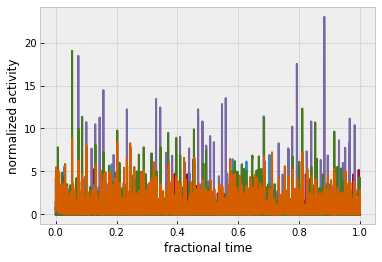

In [6]:
x = np.linspace(0, 1, len(data[0]))

for subdata in rdata[::2]:
    plt.plot(x, subdata[0])
    
plt.xlabel('fractional time')
plt.ylabel('normalized activity')
plt.show()

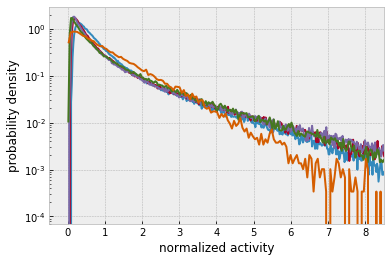

In [7]:
for subdata in rdata[::2]:
    x, y = neurenorm.make_histogram(subdata)
    plt.yscale('log')
    plt.xlim(-0.5,8.5)
    plt.plot(x, y)
plt.ylabel('probability density')
plt.xlabel('normalized activity')
plt.show()

In [8]:
p_zero, p_errs, cluster_sizes = neurenorm.compute_p_trajectory(rdata)

In [9]:
def neg_log(data):
    return -np.log(data)

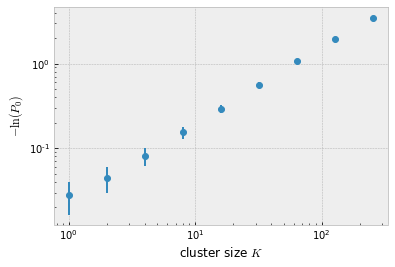

In [10]:
errs = neg_log(p_zero + p_errs / 2) - neg_log(p_zero - p_errs / 2)
plt.errorbar(cluster_sizes, neg_log(p_zero), yerr=errs, fmt='o')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('cluster size $K$')
plt.ylabel('$-\ln(P_0)$')
plt.show()

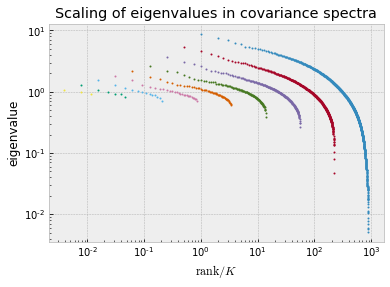

In [11]:
for index, subdata in enumerate(rdata):
    eig_vals = neurenorm.correlation_matrix_eigenvalues_sorted(subdata)
    x = np.arange(1, len(eig_vals) + 1) / (2**index)
    plt.plot(x, eig_vals, 'o', markersize=1)
    
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\mathrm{rank} / K$')
plt.ylabel('eigenvalue')
plt.title('Scaling of eigenvalues in covariance spectra')
plt.show()